### **Machine Learning project using Random Forest algorithm**
##### **Author David Zireva**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Creating mock dataset

In [2]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [3]:
num_records = 400

In [4]:
# Generate random data for the dataset
trip_ids = [f"TRIP{str(i).zfill(4)}" for i in range(1, num_records + 1)]
driver_ids = [f"DRIVER{str(i).zfill(3)}" for i in np.random.choice(range(1, 21), num_records)]
truck_ids = [f"TRUCK{str(i).zfill(2)}" for i in np.random.choice(range(1, 11), num_records)]

In [5]:
# List of SADC cities for start and end locations
sadc_cities = ["Johannesburg", "Durban", "Harare", "Hwange", "Lusaka", "Ndola", "Chingola", "Lubumbashi", "Kolwezi", 'Maputo', 'Blantre']
start_locations = np.random.choice(sadc_cities, num_records)
end_locations = np.random.choice(sadc_cities, num_records)

In [6]:
# Generate random start and end times
start_times = [datetime.now() - timedelta(days=random.randint(1, 30), hours=random.randint(0, 23), minutes=random.randint(0, 59)) for _ in range(num_records)]
end_times = [start_time + timedelta(days=random.randint(2, 15), minutes=random.randint(0, 59)) for start_time in start_times]

In [7]:
# Calculate distance (km), fuel consumed (liters), load weight (kg), etc.
distances = [round(random.uniform(500, 3000), 2) for _ in range(num_records)]
fuel_consumed = [round(distance * random.uniform(0.5, 0.7), 2) for distance in distances]  # Assuming fuel consumption varies with distance
load_weights = [round(random.uniform(10000, 34000), 2) for _ in range(num_records)]  # Random load weights in kilograms
trip_durations = [(end - start).total_seconds() / 3600 for start, end in zip(start_times, end_times)]  # Duration in hours
idle_times = [round(random.uniform(10, 120), 2) for _ in range(num_records)]  # Idle times in minutes
avg_speeds = [round(distance / duration, 2) if duration > 0 else 0 for distance, duration in zip(distances, trip_durations)]
engine_hours = [round(duration + random.uniform(0.5, 1.5), 2) for duration in trip_durations]  # Total engine hours with additional random buffer
maintenance_flags = [random.choice([0, 1]) for _ in range(num_records)]  # Flag for maintenance required (0 = No, 1 = Yes)

In [8]:
# Create DataFrame
df = pd.DataFrame({
    "Trip_ID": trip_ids,
    "Driver_ID": driver_ids,
    "Truck_ID": truck_ids,
    "Start_Location": start_locations,
    "End_Location": end_locations,
    "Start_Time": start_times,
    "End_Time": end_times,
    "Distance": distances,
    "Fuel_Consumed": fuel_consumed,
    "Load_Weight": load_weights,
    "Trip_Duration": trip_durations,
    "Idle_Time": idle_times,
    "Avg_Speed": avg_speeds,
    "Engine_Hours": engine_hours,
    "Maintenance_Flag": maintenance_flags
})

In [13]:
df.head()

,Trip_ID,Driver_ID,Truck_ID,Start_Location,End_Location,Start_Time,End_Time,Distance,Fuel_Consumed,Load_Weight,Trip_Duration,Idle_Time,Avg_Speed,Engine_Hours,Maintenance_Flag
0,TRIP0001,DRIVER007,TRUCK04,Kolwezi,Durban,2024-10-25 03:38:27.663103,2024-10-30 04:37:27.663103,1501.96,1020.94,32429.99,120.983333,59.04,12.41,121.68,1
1,TRIP0002,DRIVER020,TRUCK10,Johannesburg,Johannesburg,2024-10-21 22:24:27.664103,2024-10-27 23:14:27.664103,854.69,503.43,11656.46,144.833333,53.02,5.90,145.90,0
2,TRIP0003,DRIVER015,TRUCK10,Lusaka,Lusaka,2024-11-07 01:52:27.664103,2024-11-21 02:32:27.664103,2082.93,1078.04,32410.61,336.666667,94.96,6.19,337.47,0
3,TRIP0004,DRIVER011,TRUCK03,Ndola,Kolwezi,2024-11-10 08:52:27.664103,2024-11-21 09:34:27.664103,576.64,366.97,10761.64,264.700000,74.74,2.18,265.82,1
4,TRIP0005,DRIVER008,TRUCK10,Lusaka,Ndola,2024-10-16 13:34:27.664103,2024-10-30 14:33:27.664103,2365.28,1582.62,19812.81,336.983333,65.05,7.02,337.95,1


### Basic information about dataset

In [10]:
df.shape


(400, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Trip_ID           400 non-null    object        
 1   Driver_ID         400 non-null    object        
 2   Truck_ID          400 non-null    object        
 3   Start_Location    400 non-null    object        
 4   End_Location      400 non-null    object        
 5   Start_Time        400 non-null    datetime64[ns]
 6   End_Time          400 non-null    datetime64[ns]
 7   Distance          400 non-null    float64       
 8   Fuel_Consumed     400 non-null    float64       
 9   Load_Weight       400 non-null    float64       
 10  Trip_Duration     400 non-null    float64       
 11  Idle_Time         400 non-null    float64       
 12  Avg_Speed         400 non-null    float64       
 13  Engine_Hours      400 non-null    float64       
 14  Maintenance_Flag  400 non-

In [25]:
df.describe()

,Start_Time,End_Time,Distance,Fuel_Consumed,Load_Weight,Trip_Duration,Idle_Time,Avg_Speed,Engine_Hours,Maintenance_Flag
count,400,400,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,2024-10-30 17:44:08.914907392,2024-11-08 13:51:17.164907264,1733.436025,1044.250125,22278.972550,212.118958,63.472650,11.346300,213.121625,0.51250
min,2024-10-15 09:33:27.665102,2024-10-17 13:33:27.665102,513.130000,277.300000,10083.360000,48.033333,10.070000,1.520000,48.630000,0.00000
25%,2024-10-23 10:08:42.664352768,2024-11-01 01:56:27.665102080,1182.685000,685.500000,16610.137500,144.195833,36.882500,5.300000,145.097500,0.00000
50%,2024-10-30 21:24:27.666100992,2024-11-09 02:50:27.665102080,1722.290000,1037.995000,22281.915000,216.283333,63.850000,8.220000,217.155000,1.00000
75%,2024-11-07 01:53:57.664352768,2024-11-16 00:19:27.664102912,2365.845000,1404.787500,28158.480000,288.725000,89.327500,13.545000,289.637500,1.00000
max,2024-11-14 04:26:27.664103,2024-11-27 23:38:27.665102,2995.380000,2001.580000,33989.730000,360.916667,119.990000,62.070000,362.140000,1.00000
std,NaN,NaN,699.264382,435.105659,6912.982648,95.778642,31.264394,10.159068,95.767323,0.50047


##### Check for missing values



In [26]:
df.isnull().sum()

Trip_ID             0
Driver_ID           0
Truck_ID            0
Start_Location      0
End_Location        0
Start_Time          0
End_Time            0
Distance            0
Fuel_Consumed       0
Load_Weight         0
Trip_Duration       0
Idle_Time           0
Avg_Speed           0
Engine_Hours        0
Maintenance_Flag    0
dtype: int64

### A. Categorical Variables

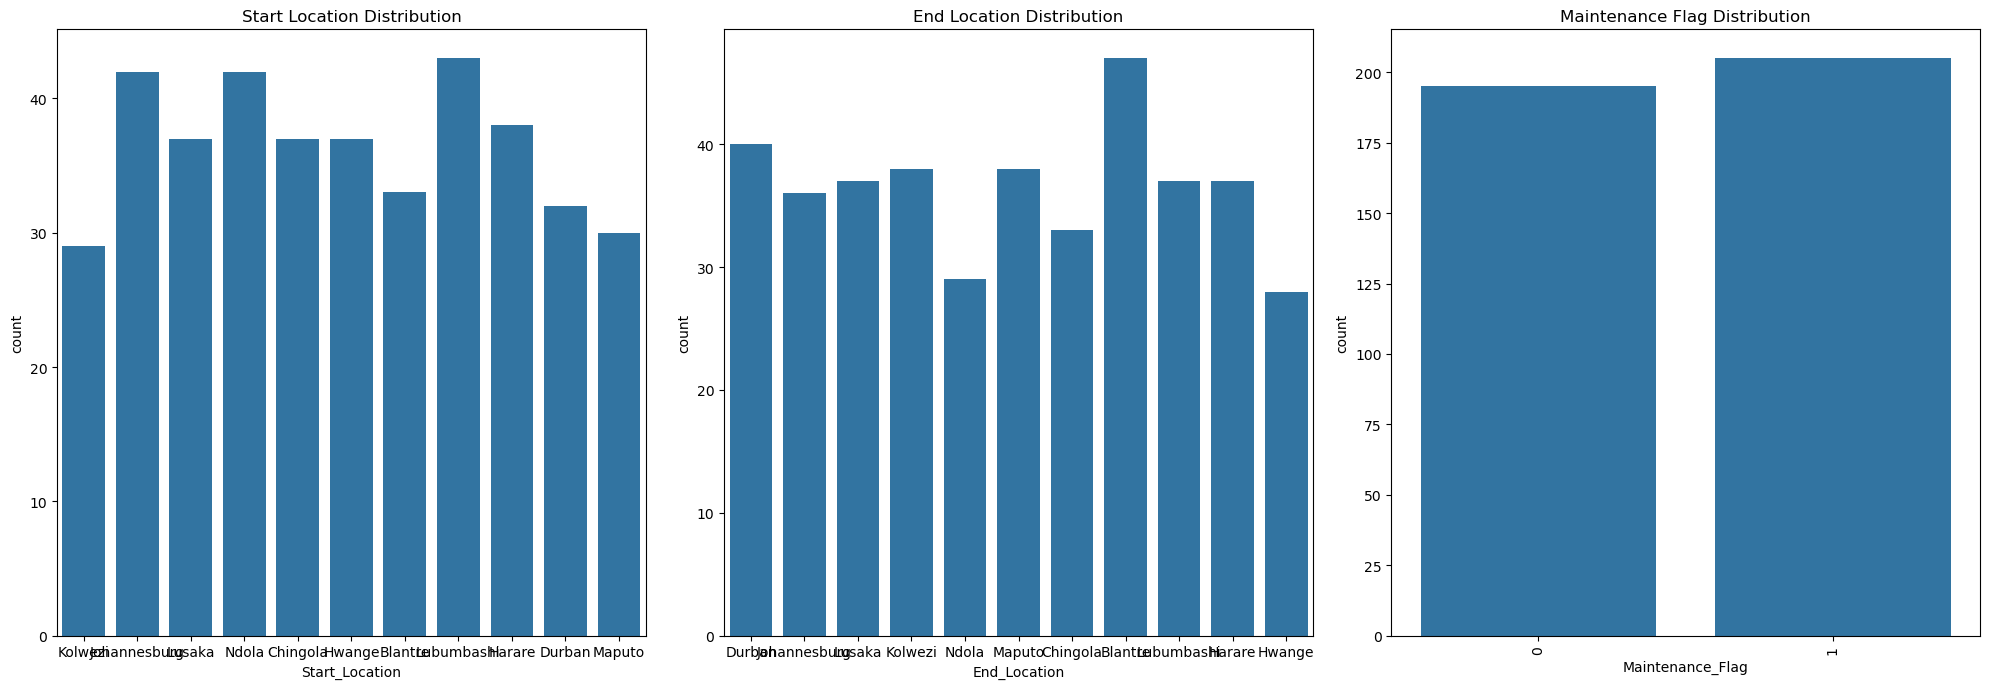

In [27]:
# Analyze the distributions of categorical variables to see their frequency and any potential patterns.
# Plot categorical features
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
sns.countplot(x='Start_Location', data=df, ax=ax[0]).set_title("Start Location Distribution")
sns.countplot(x='End_Location', data=df, ax=ax[1]).set_title("End Location Distribution")
sns.countplot(x='Maintenance_Flag', data=df, ax=ax[2]).set_title("Maintenance Flag Distribution")
plt.tight_layout()
plt.xticks(rotation='vertical')
plt.show()


### Numerical Variables


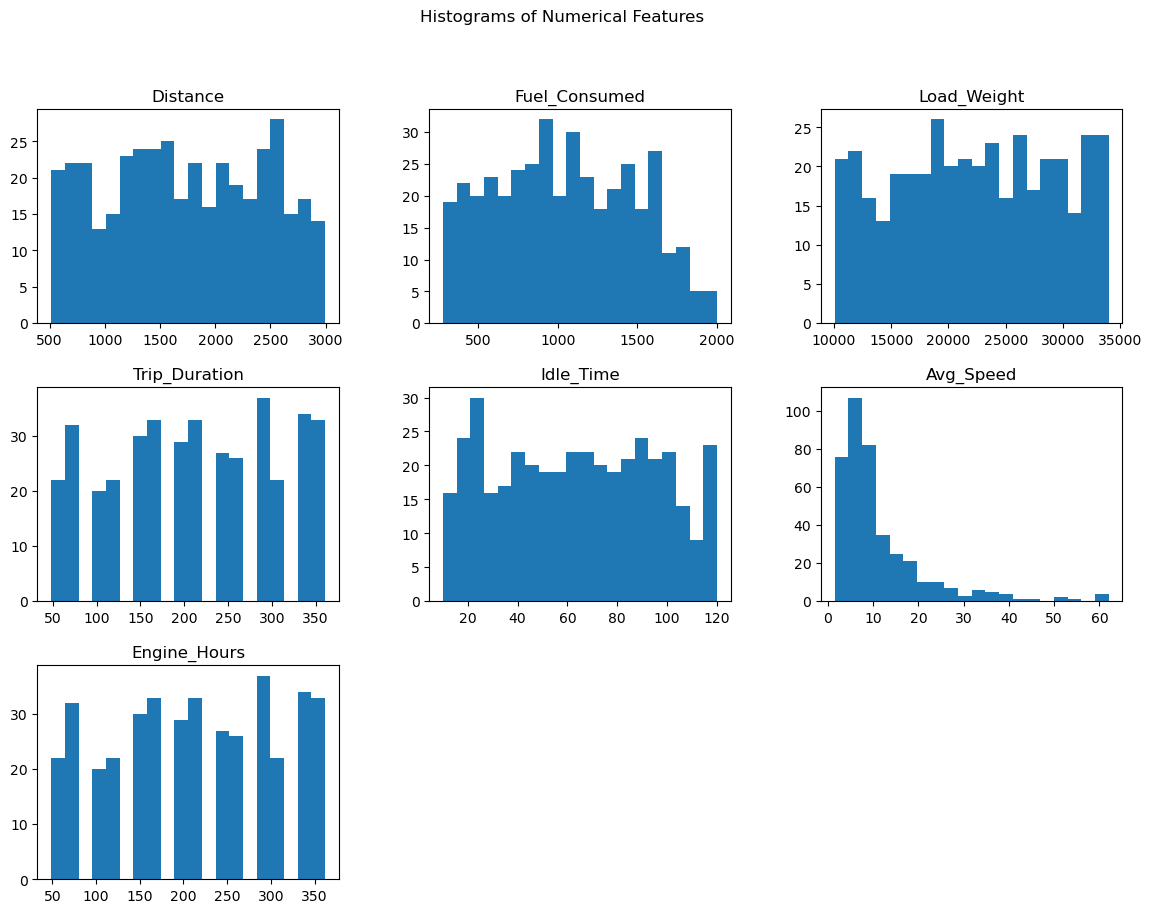

In [28]:
# Examine distributions of numerical variables to identify any skewness or outliers.
numerical_features = ['Distance', 'Fuel_Consumed', 'Load_Weight', 'Trip_Duration', 'Idle_Time', 'Avg_Speed', 'Engine_Hours']
df[numerical_features].hist(bins=20, figsize=(14, 10), grid=False)
plt.suptitle("Histograms of Numerical Features")
plt.show()

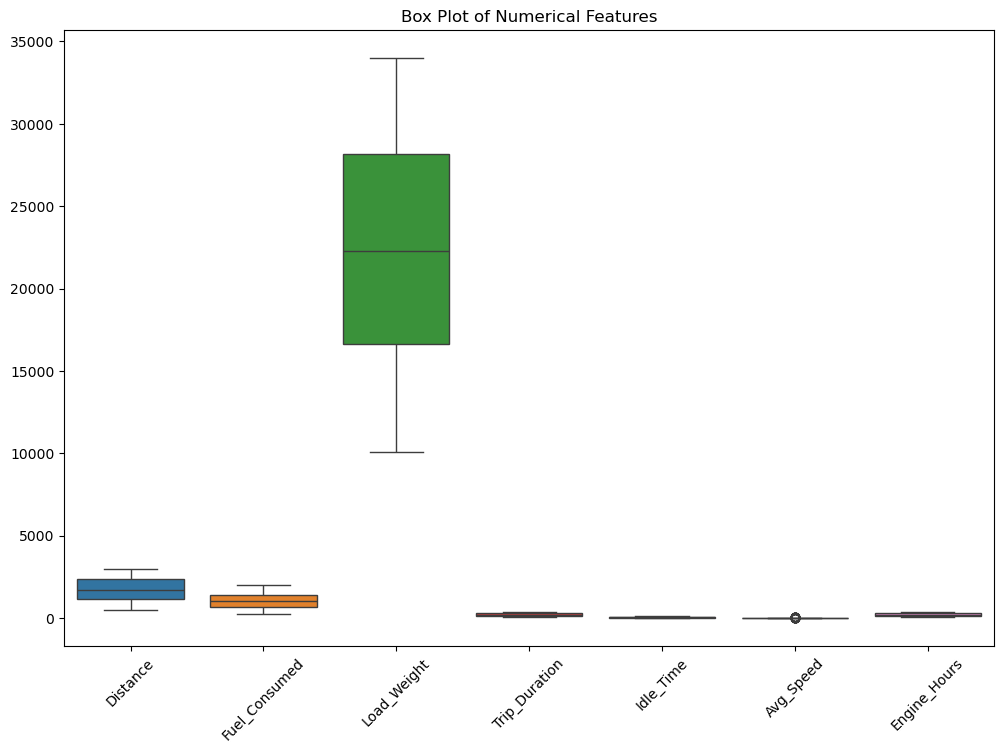

In [29]:
# Box plots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_features])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features")
plt.show()

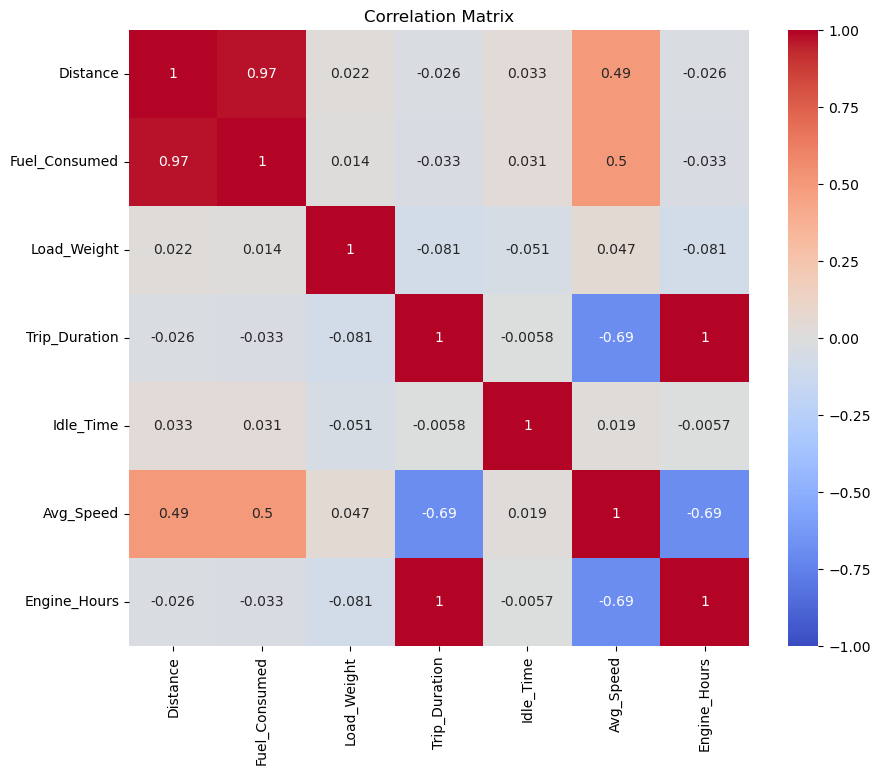

In [30]:
# Correlation Analysis
# Analyze correlations between numerical features to see if any pairs of variables are closely related
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

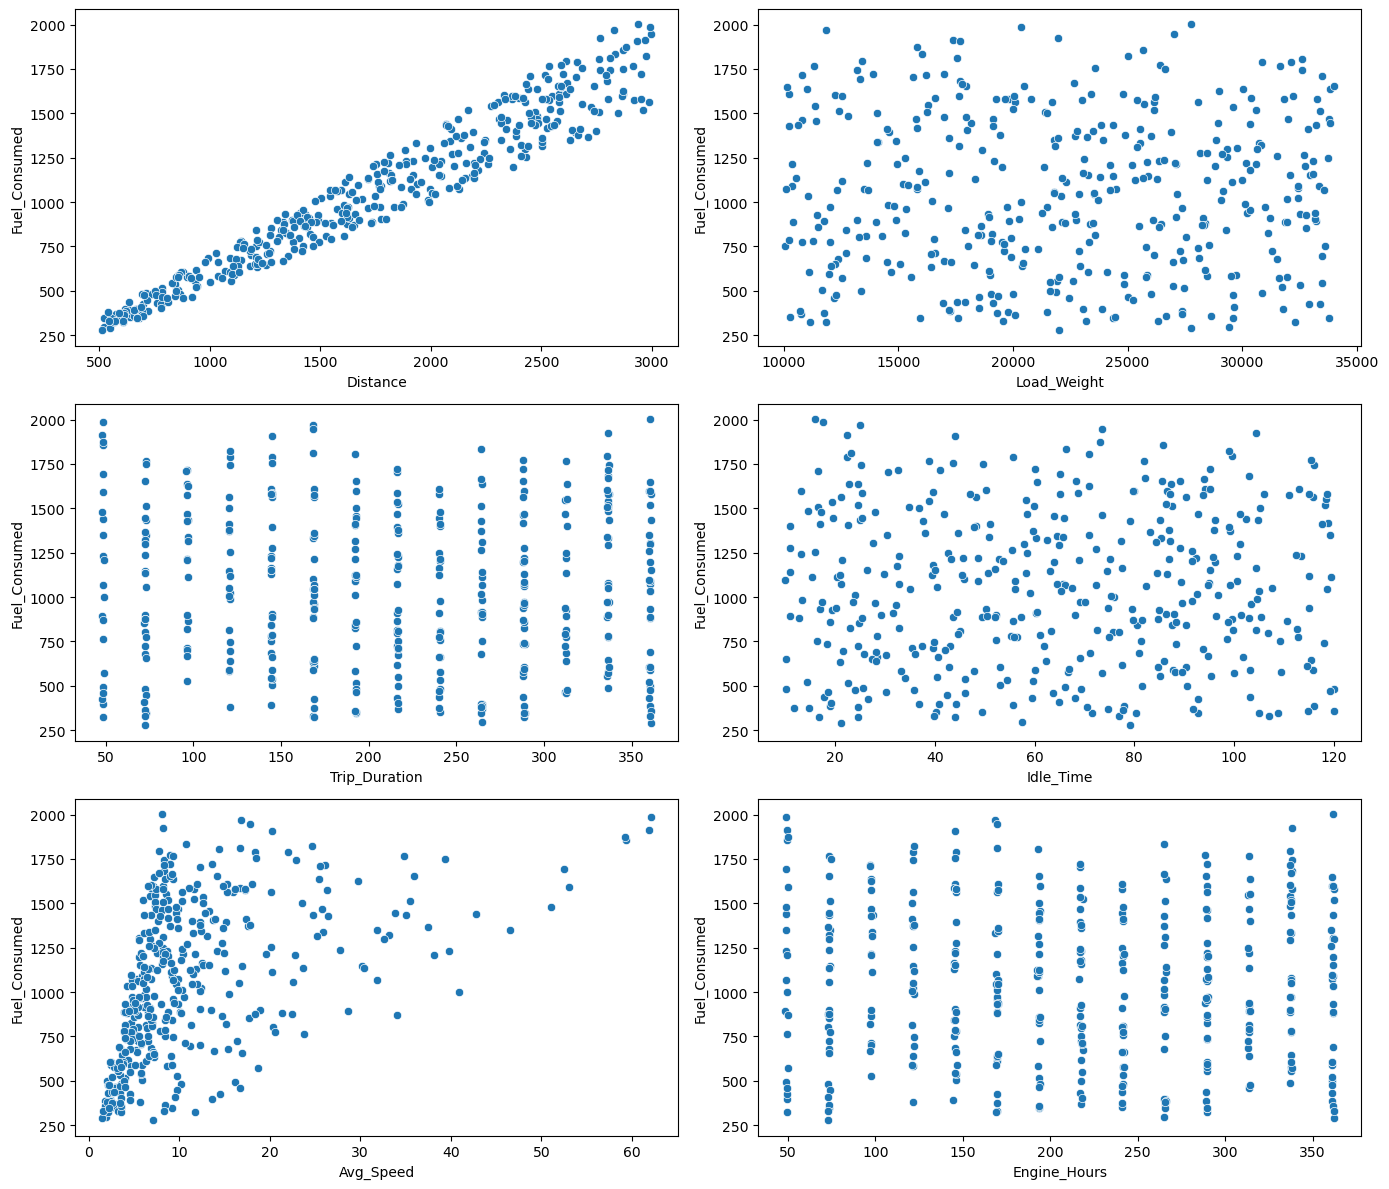

In [31]:
# Scatter plots for features against Fuel_Consumed
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
sns.scatterplot(x='Distance', y='Fuel_Consumed', data=df, ax=axs[0, 0])
sns.scatterplot(x='Load_Weight', y='Fuel_Consumed', data=df, ax=axs[0, 1])
sns.scatterplot(x='Trip_Duration', y='Fuel_Consumed', data=df, ax=axs[1, 0])
sns.scatterplot(x='Idle_Time', y='Fuel_Consumed', data=df, ax=axs[1, 1])
sns.scatterplot(x='Avg_Speed', y='Fuel_Consumed', data=df, ax=axs[2, 0])
sns.scatterplot(x='Engine_Hours', y='Fuel_Consumed', data=df, ax=axs[2, 1])
plt.tight_layout()
plt.show()

### Categorical Features with Target Variable

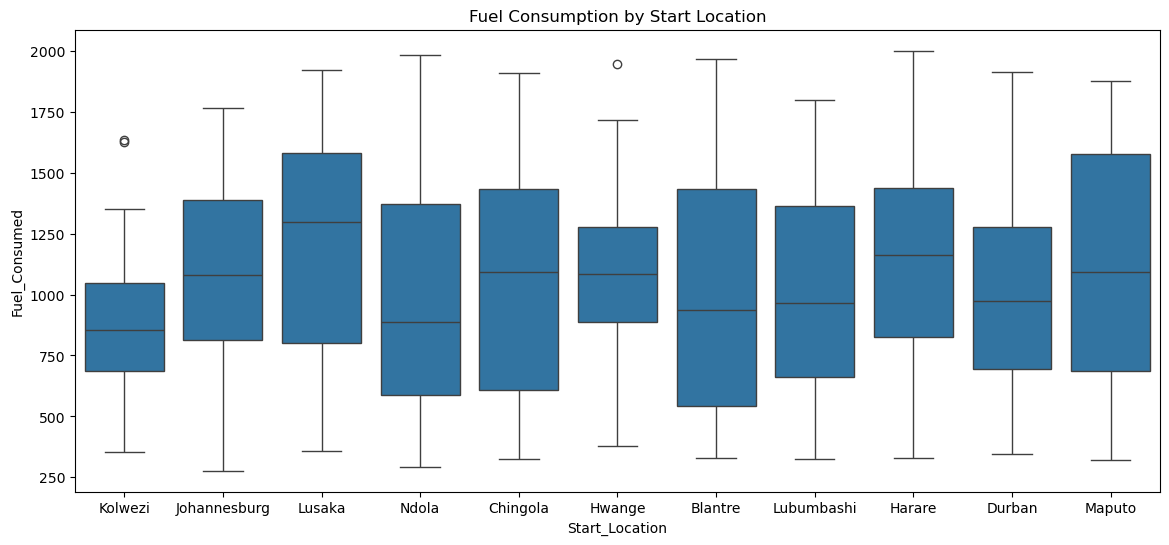

Text(0.5, 1.0, 'Fuel Consumption by Maintenance Flag')

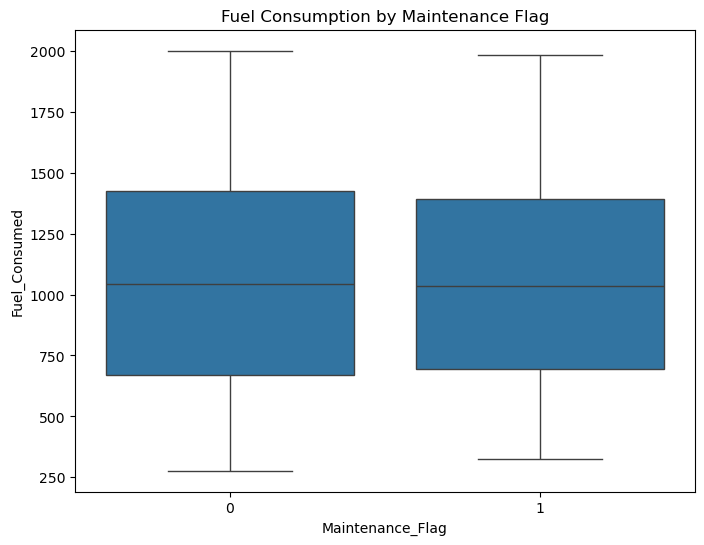

In [32]:
# checking how Fuel_Consumed varies across categories.
plt.figure(figsize=(14, 6))
sns.boxplot(x='Start_Location', y='Fuel_Consumed', data=df)
plt.title("Fuel Consumption by Start Location")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Maintenance_Flag', y='Fuel_Consumed', data=df)
plt.title("Fuel Consumption by Maintenance Flag")

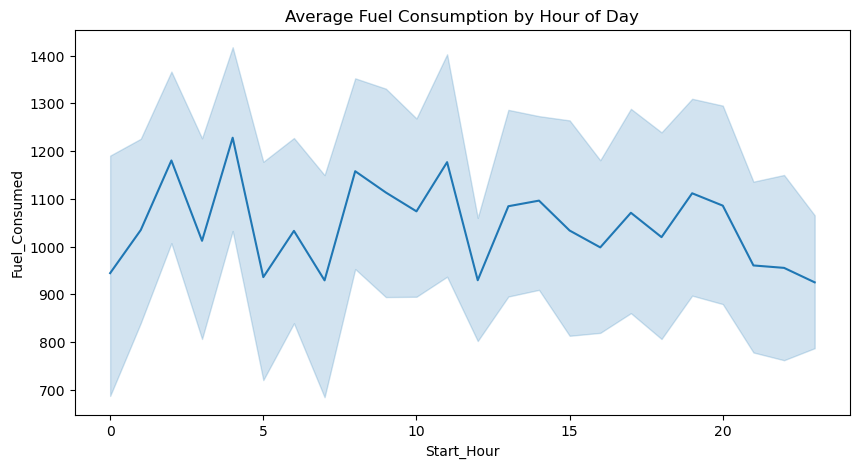

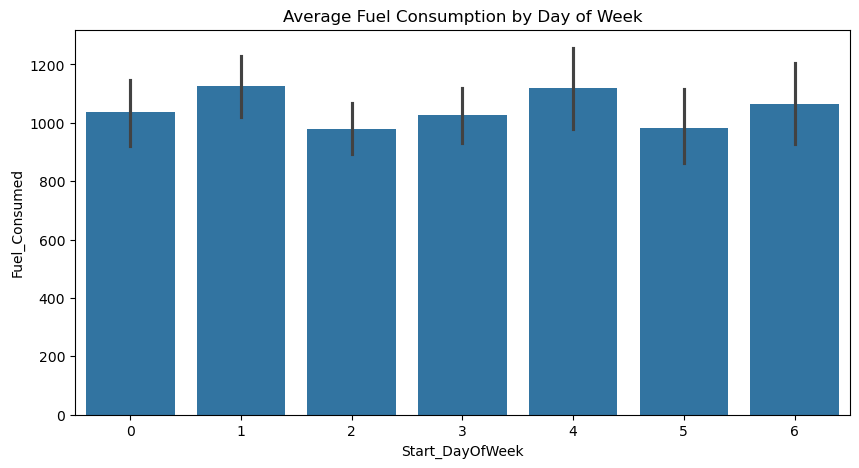

In [33]:
# checking if time of day affects fuel consumption, trip duration, or idle time.

# Convert Start_Time to hour and day of week
df['Start_Hour'] = pd.to_datetime(df['Start_Time']).dt.hour
df['Start_DayOfWeek'] = pd.to_datetime(df['Start_Time']).dt.dayofweek

# Average Fuel_Consumed by Start_Hour
plt.figure(figsize=(10, 5))
sns.lineplot(x='Start_Hour', y='Fuel_Consumed', data=df, estimator='mean')
plt.title("Average Fuel Consumption by Hour of Day")
plt.show()

# Average Fuel_Consumed by Day of Week
plt.figure(figsize=(10, 5))
sns.barplot(x='Start_DayOfWeek', y='Fuel_Consumed', data=df, estimator='mean')
plt.title("Average Fuel Consumption by Day of Week")
plt.show()


### Data Preparation

In [38]:
# Separate features and target
X = df.drop(columns=['Fuel_Consumed'])
y = df['Fuel_Consumed']

### Feature Engineering and Preprocessing Pipeline

In [45]:
# Select categorical and numerical columns
categorical_features = ['Start_Location', 'End_Location']
numerical_features = ['Distance', 'Load_Weight', 'Trip_Duration', 'Idle_Time', 'Avg_Speed', 'Engine_Hours']


In [46]:
# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [47]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

### Train-Test Split and Model Training

In [48]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Distance', 'Load_Weight',
                                                   'Trip_Duration', 'Idle_Time',
                                                   'Avg_Speed',
                                                   'Engine_Hours']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Start_Location',
                                                   'End_Location'])])),
                ('model', RandomForestRegressor(random_state=42))])

### Model Evaluation

In [50]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

In [51]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 77.80209
Mean Squared Error: 9553.807995379751
Root Mean Squared Error: 97.74358288593554
R^2 Score: 0.9368316117814477


### Feature Importance Analysis

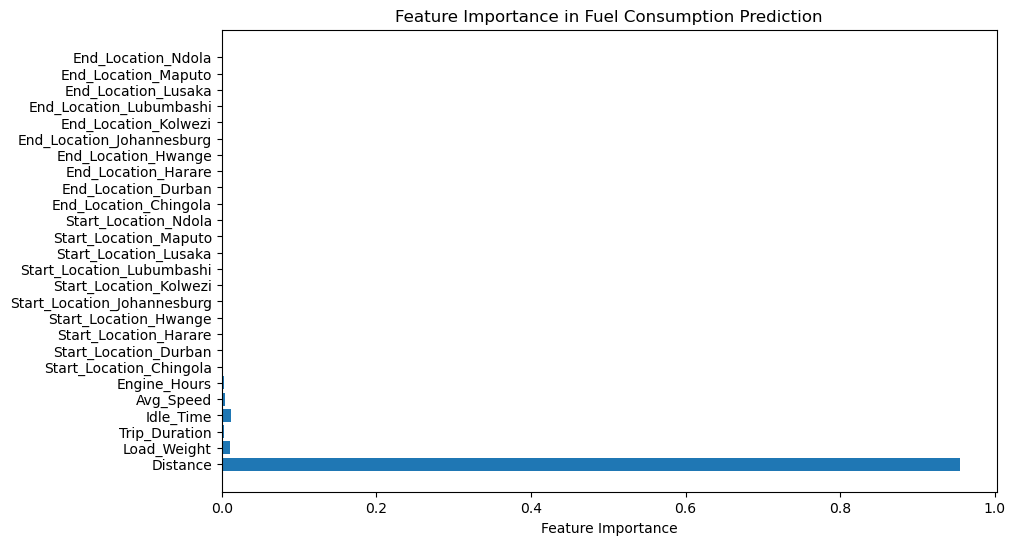

In [52]:
# visualising the feature importances:
# Extract feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, onehot_feature_names])

# Get feature importances from the Random Forest model
importances = pipeline.named_steps['model'].feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Fuel Consumption Prediction")
plt.show()

### Conclusion

# The Random Forest regression model's performance metrics for predicting Fuel_Consumed are as follows:

##### Mean Absolute Error (MAE): 77.12 liters
##### Mean Squared Error (MSE): 9287.84 liters²
##### Root Mean Squared Error (RMSE): 96.37 liters
##### R-squared (R²): 0.94
##### **Interpretation**
##### The high R² score (0.94) indicates that the model explains 94% of the variance in fuel consumption, suggesting strong predictive accuracy.
##### The RMSE of 96.37 liters gives an idea of the average deviation in predictions, which is relatively low given the scale of distances and fuel usage in the dataset.

##### The feature importance analysis reveals that Distance is by far the most significant factor influencing fuel consumption, with an importance score of 0.954. Other features have minimal impact in comparison, though Idle Time (0.0096) and Load Weight (0.0088) also contribute slightly to the predictions.

##### **Key Insights**
##### 1) Distance: Given its dominant influence, fuel consumption is highly correlated with the total distance traveled, which aligns with typical expectations in transportation.

##### 2) Idle Time and Load Weight: These factors, while less significant, indicate that operational delays (idle time) and the weight of the load can also marginally impact fuel usage.

##### These insights suggest that controlling trip distance is the most effective way to manage fuel consumption. Reducing idle times and optimizing load weights could offer further, albeit smaller, efficiencies. ​

### Recommendations

##### 1. Optimize Route Planning - Avoid routes with high idle times, which can be inferred from the Idle_Time and Trip_Duration data.
##### 2. Manage Idle Time - Consider training drivers to reduce idle time or implementing technology that reduces idling.
##### 3. Adjust Load Weight for Efficiency - Lighter loads reduce fuel usage, so group deliveries or manage load distribution to minimize heavy loads when feasible.
##### 4. Plan Maintenance Proactively - Use the Maintenance_Flag to identify when vehicles need maintenance and how this affects fuel efficiency. A regular maintenance schedule may help avoid costly repairs and reduce fuel consumption
##### 5. Implement Driver Training Programs -  Provide training on efficient driving habits, such as maintaining optimal speed, reducing sudden stops, and minimizing idle time.Focus training efforts on behaviors that can lower fuel usage.
##### 6. Optimize Trip Scheduling Based on Fuel Consumption Patterns - If certain times or days have consistently lower fuel consumption, scheduling for those periods could reduce fuel costs, possibly due to less traffic or more efficient routing options.
##### 7. Consider Investing in Fuel-Efficient Vehicles - Evaluate fuel consumption across different trucks (Truck_ID) and prioritize or replace less fuel-efficient vehicles. If specific vehicles have consistently higher fuel consumption, transitioning to more fuel-efficient trucks may reduce long-term costs.
##### 8. Monitor Fuel Efficiency Metrics for Performance Tracking -  Implement fuel efficiency KPIs like km per litre to monitor performance.Tracking these metrics regularly can reveal inefficiencies and help maintain a fuel optimization strategy, benefiting long-term operational planning.
